# Proyecto: PostgreSQL en Python con SQLAlchemy
Se analizan los libros de una biblioteca, toda su infromación está ditribuida en 5 tablas: books, authors, ratings, reviews y publishers.
El objetivo es llegar a conclusiones mediante el análisis de los datos (consultas SQL).

En el apéndice A se muestra cómo subir una base de datos a la nube usando "render.com".

En el apéndice B se muestra cómo conectarse a una base de datos postgreSQL y hacer consultas SQL desde VSCode.

## Lectura de datos (conección con la base de datos)

In [53]:
# Import libraries
import pandas as pd
from sqlalchemy import create_engine
from PIL import Image
import matplotlib.pyplot as plt

In [54]:
# Define the parameters to connect to the database
db_config = {
    'user': 'practicum_student',            # username
    'pwd': 'QnmDH8Sc2TQLvy2G3Vvh7',         # password
    # server address / hostname
    'host': 'yp-trainers-practicum.cluster-czs0gxyx2d8w.us-east-1.rds.amazonaws.com',
    'port': 5432,                           # connection port
    'db': 'data-analyst-final-project-db'}  # database name

# Create database connection string .
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
# Connect to the database.
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

A continuación se mostrarán las tablas que se usarán. Se crea una función para realizar la consulta en la base de datos.

In [55]:
def print_sql_query(query: str, head=3)-> None:
    '''Function to perform SQL query'''
    
    # Obtain data from query and store it in a DataFrame
    df = pd.io.sql.read_sql(query, con = engine)

    # Show DataFrame
    print(df.head(head))
    return

In [56]:
# Create a SQL query
query = '''SELECT * FROM books;'''
print_sql_query(query)

   book_id  author_id                                              title  \
0        1        546                                       'Salem's Lot   
1        2        465                 1 000 Places to See Before You Die   
2        3        407  13 Little Blue Envelopes (Little Blue Envelope...   

   num_pages publication_date  publisher_id  
0        594       2005-11-01            93  
1        992       2003-05-22           336  
2        322       2010-12-21           135  


In [57]:
query = '''SELECT * FROM authors;'''
print_sql_query(query)

   author_id                          author
0          1                      A.S. Byatt
1          2  Aesop/Laura Harris/Laura Gibbs
2          3                 Agatha Christie


In [58]:
query = '''SELECT * FROM ratings;'''
print_sql_query(query)

   rating_id  book_id       username  rating
0          1        1     ryanfranco       4
1          2        1  grantpatricia       2
2          3        1   brandtandrea       5


In [59]:
query = '''SELECT * FROM reviews;'''
print_sql_query(query)

   review_id  book_id      username  \
0          1        1  brandtandrea   
1          2        1    ryanfranco   
2          3        2      lorichen   

                                                text  
0  Mention society tell send professor analysis. ...  
1  Foot glass pretty audience hit themselves. Amo...  
2  Listen treat keep worry. Miss husband tax but ...  


In [60]:
query = '''SELECT * FROM publishers;'''
print_sql_query(query)

   publisher_id  publisher
0             1        Ace
1             2   Ace Book
2             3  Ace Books


La relación de las tablas se muestra a continuación.

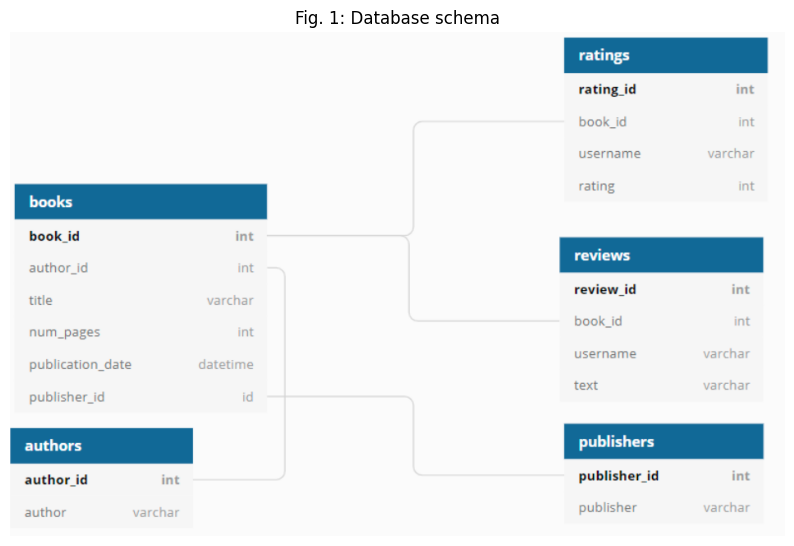

In [61]:
img = Image.open('../images/tables.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 1: Database schema')
plt.show()

## Análisis de los datos

### Encuentra el número de libros publicados después del 1 de enero de 2000.

Se publicaron 819 libros diferentes.

In [62]:
query = '''
SELECT COUNT(DISTINCT book_id) AS N_BOOKS
FROM books
WHERE publication_date > '2000-01-01'
'''
print_sql_query(query)

   n_books
0      819


### Encuentra el número de reseñas de usuarios y la calificación promedio para cada libro.

Los libros con mejor calificación promedio son aquellos que tuvieron pocas reseñas (de 2 a 4).

In [63]:
query = '''
SELECT book_id, COUNT(rating_id) AS N_REVIEWS, AVG(rating) AS MEAN_SCORE
FROM ratings
GROUP BY book_id
ORDER BY MEAN_SCORE DESC
'''
print_sql_query(query, 20)

    book_id  n_reviews  mean_score
0       518          2         5.0
1       732          2         5.0
2       347          3         5.0
3       610          2         5.0
4       330          2         5.0
5       229          2         5.0
6       275          2         5.0
7       553          4         5.0
8       213          2         5.0
9       993          2         5.0
10      972          2         5.0
11       57          2         5.0
12      224          2         5.0
13       17          4         5.0
14      902          2         5.0
15      459          2         5.0
16      297          2         5.0
17      182          2         5.0
18      136          2         5.0
19      418          2         5.0


### Identifica la editorial que ha publicado el mayor número de libros con más de 50 páginas (esto te ayudará a excluir folletos y publicaciones similares de tu análisis).

La editorial "Penguin Books" ha publicado más libros que todas la demas editoriales (42 libros publicados).

In [64]:
query = '''
SELECT publishers.publisher, COUNT(DISTINCT books.book_id) AS N_BOOKS
FROM books
INNER JOIN publishers ON publishers.publisher_id = books.publisher_id
WHERE books.num_pages > 50
GROUP BY publishers.publisher
ORDER BY N_BOOKS DESC
LIMIT 1;'''
print_sql_query(query)

       publisher  n_books
0  Penguin Books       42


### Identifica al autor que tiene la más alta calificación promedio del libro: mira solo los libros con al menos 50 calificaciones.

J.K. Rowling/Mary GrandPré es el autor del libro con la más alta calificación promedio entre todas las editoriales. Tenia que ser de Harry Potter.

In [65]:
query = '''SELECT SUB2.book_id, SUB2.MEAN_SCORE, authors.author
FROM
    (
    SELECT SUB1.book_id, SUB1.MEAN_SCORE, books.author_id
    FROM
        (
        SELECT book_id, COUNT(rating) AS count, AVG(rating) AS MEAN_SCORE
        FROM ratings
        GROUP BY book_id
        HAVING COUNT(rating)>=50
        ORDER BY MEAN_SCORE DESC
        LIMIT 1
        ) AS SUB1
    INNER JOIN books ON books.book_id = SUB1.book_id
    ) AS SUB2
INNER JOIN authors ON authors.author_id = SUB2.author_id
'''
print_sql_query(query)

   book_id  mean_score                      author
0      302    4.414634  J.K. Rowling/Mary GrandPré


### Encuentra el número promedio de reseñas de texto entre los usuarios que calificaron más de 50 libros.

El usuario con username 'paul88' en promedio calificó 56 libros y solo 6 usurios calificaron más de 50 libros.

In [66]:
query = '''
SELECT SUB1.username, AVG(SUB1.N_SCORES) AS MEAN_SCORES
FROM
    (
    SELECT username, COUNT(rating_id) AS N_SCORES
    FROM ratings
    GROUP BY username
    HAVING COUNT(rating_id) > 50
    ) AS SUB1
INNER JOIN reviews ON reviews.username = SUB1.username
GROUP BY SUB1.username
ORDER BY MEAN_SCORES DESC
'''
print_sql_query(query,20)

         username  mean_scores
0          paul88         56.0
1      martinadam         56.0
2       richard89         55.0
3     sfitzgerald         55.0
4  jennifermiller         53.0
5          xdavis         51.0


## Apéndice A
A continuación se muestra cómo subir una base de datos postgreSQL al servidor "render.com". Al ingresar al sitio "render.com" se agrega un nuevo servicio "Postgre" (fig. 1), y se agregan los datos necesarios. Al finalizar el proceso, se obtiene una configuracion parecida a la mostrada en la fig. 2.

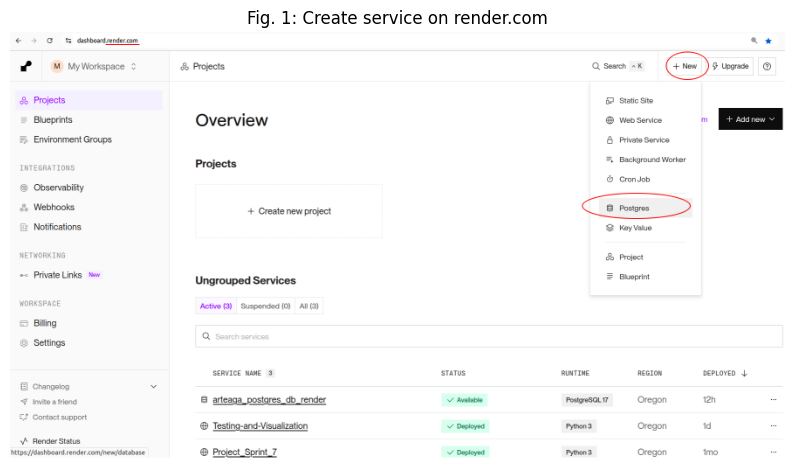

In [67]:
img = Image.open('../images/render_db.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 1: Create service on render.com')
plt.show()

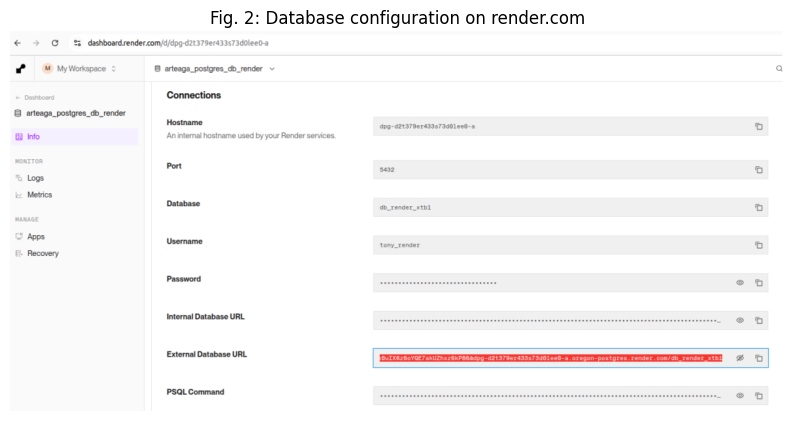

In [68]:
img = Image.open('../images/render_db2.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 2: Database configuration on render.com')
plt.show()

La configuración en Python quedaría algo así:

```
db_config = {'user': 'tony_render',
             'pwd': 'rpRJ4a8x0uIX6z6oYQE7akUZhxz6kP86',
             'host': 'dpg-d2t379er433s73d0lee0-a.oregon-postgres.render.com',
             'port': 5432,
             'db': 'db_render_xtb1'
             }
# username, password, server address, port, database name
```

## Apéndice B
A continuación se muestra cómo conectarse a una base de datos postgreSQL y hacer consultas SQL desde VSCode. En VSCde se debe instalar la extensión "PostgreSQL" (fig. 1), después, se agrega la base de datos (fig. 2).

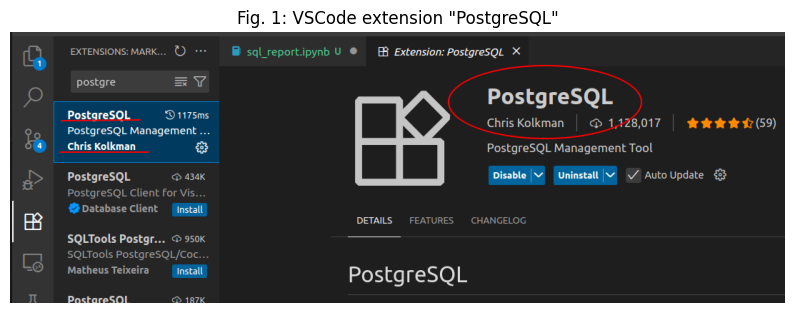

In [69]:
img = Image.open('../images/extension.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 1: VSCode extension "PostgreSQL"')
plt.show()

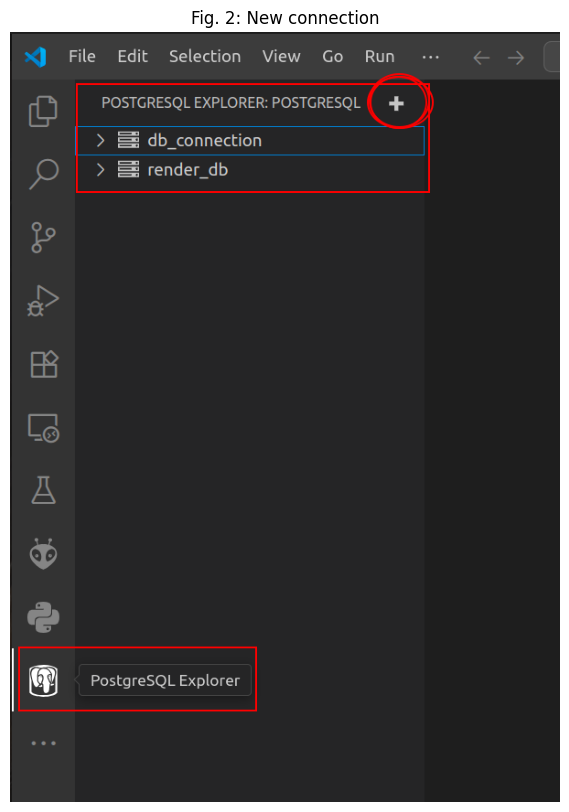

In [70]:
img = Image.open('../images/postgresql_vscode.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 2: New connection')
plt.show()

Finalmente, se crea un script para consultas SQL (fig. 3).

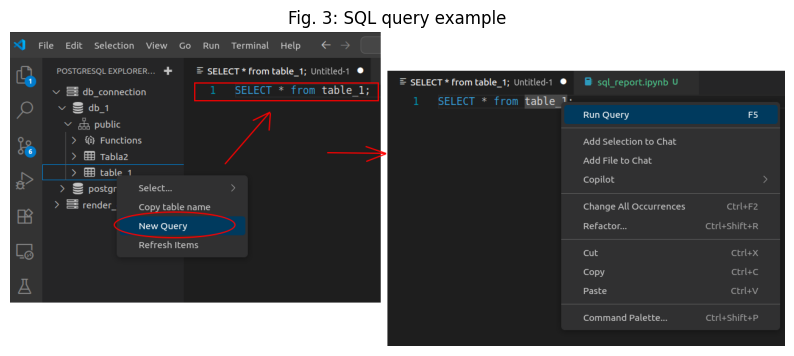

In [72]:
img = Image.open('../images/query.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Fig. 3: SQL query example')
plt.show()